<a href="https://colab.research.google.com/github/good0neighbour/ESTCampAI/blob/main/%EC%9D%8C%EC%84%B1%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D/ex02_Transformer%EA%B8%B0%EB%B0%98_Audio_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 작업디렉토리 변경
%cd /content/drive/MyDrive/ESTCampAI/음성데이터분석

/content/drive/MyDrive/ESTCampAI/음성데이터분석


### 학습목표
- transformer기반의 wave2vec2 모델 활용(파인튜닝)

In [2]:
# 필요 라이브러리 설치
!pip install transformers datasets torchcodec evaluate accelerate

### 데이터셋 로딩

In [3]:
from datasets import load_dataset, Audio # 데이터로딩 함수, 오디오 로딩클래스

In [4]:
origin = load_dataset(
    "PolyAI/minds14", # 다운받을 저장소 주소
    name = "ko-KR", # 한국어데이터 필터링
    split = "train" # 훈련용데이터로 다운로드 -> Datasets
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
origin

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 592
})

In [6]:
# 불필요한 컬럼제거
remove_data = origin.remove_columns(['path', 'transcription', 'english_transcription', 'lang_id'])

In [7]:
remove_data

Dataset({
    features: ['audio', 'intent_class'],
    num_rows: 592
})

In [8]:
# 훈련용.평가용 데이터 분리
data = remove_data.train_test_split(test_size = 0.2)

In [9]:
data

DatasetDict({
    train: Dataset({
        features: ['audio', 'intent_class'],
        num_rows: 473
    })
    test: Dataset({
        features: ['audio', 'intent_class'],
        num_rows: 119
    })
})

### 데이터탐색

In [10]:
# 데이터 샘플 하나 확인
data['train'][0]

{'audio': <datasets.features._torchcodec.AudioDecoder at 0x7bd126ee9550>,
 'intent_class': 13}

In [11]:
# 진폭데이터 확인
data['train'][0]['audio']['array']

array([0.        , 0.        , 0.        , ..., 0.00292969, 0.00195312,
       0.00219727], dtype=float32)

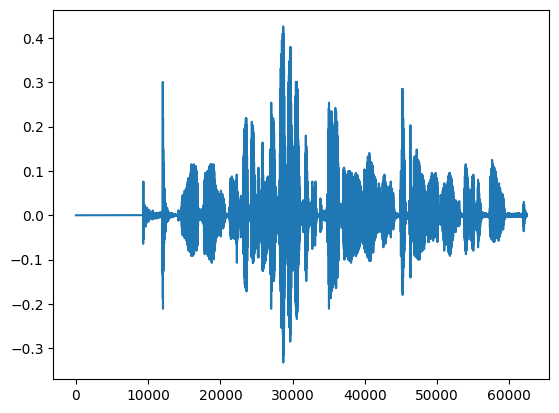

In [12]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(data['train'][0]['audio']['array'])
plt.show()

In [13]:
# 샘플링레이트 확인
data['train'][0]['audio']['sampling_rate']

8000

In [14]:
# 음원길이 확인 (전체데이터의 길의 / 샘플링레이트)
data['train'][0]['audio']['array'].shape[0] / data['train'][0]['audio']['sampling_rate']

7.801875

### 클래스번호와 라벨을 매핑하는 딕셔너리 생성

In [15]:
# 딕셔너리 생성
id2label, label2id = {}, {}

In [16]:
# 클래스명 가져오기
labels = data['train'].features['intent_class'].names
labels

['abroad',
 'address',
 'app_error',
 'atm_limit',
 'balance',
 'business_loan',
 'card_issues',
 'cash_deposit',
 'direct_debit',
 'freeze',
 'high_value_payment',
 'joint_account',
 'latest_transactions',
 'pay_bill']

In [17]:
# 딕셔너리 만들기
for i, label in enumerate(labels) :
  id2label[str(i)] = label # 숫자 -> 글자
  label2id[label] = i # 글자 -> 숫자

In [18]:
label2id

{'abroad': 0,
 'address': 1,
 'app_error': 2,
 'atm_limit': 3,
 'balance': 4,
 'business_loan': 5,
 'card_issues': 6,
 'cash_deposit': 7,
 'direct_debit': 8,
 'freeze': 9,
 'high_value_payment': 10,
 'joint_account': 11,
 'latest_transactions': 12,
 'pay_bill': 13}

### 음원데이터 리샘플링 (8000 -> 16000)

In [19]:
resample_data = data.cast_column('audio', Audio(sampling_rate = 16000))

In [20]:
# 변경된 샘플링레이트 확인
resample_data['train'][0]['audio']['sampling_rate']

16000

In [21]:
resample_data['train'][0]['audio']['array'].shape

(124830,)

In [22]:
# 음원데이터 확인하기(변환결과)
from IPython.display import display
import IPython.display

In [23]:
display(IPython.display.Audio(resample_data['train'][0]['audio']['array'], rate = 16000))

### 학습을 위한 전처리기 다운로드

In [24]:
# 사용할 모델명
model_name = "facebook/wav2vec2-xls-r-300m"

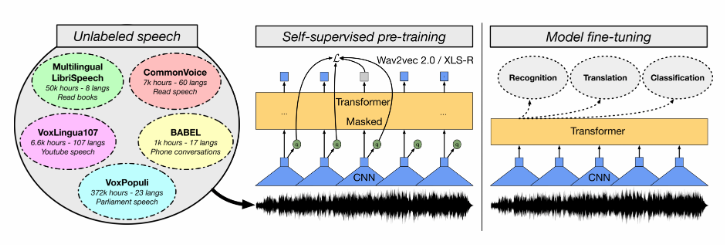

In [25]:
# 전처리기 다운로드
from transformers import AutoFeatureExtractor

In [26]:
# end2end 모델의 특성상 별다른 처리를 하지는 않음 -> 학습하기 좋은 구조정도로 맞춤(컬럼이름)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

In [27]:
# 샘플 하나 돌리기
feature_extractor(resample_data['train'][0]['audio']['array'],
                  sampling_rate = resample_data['train'][0]['audio']['sampling_rate'])

{'input_values': [array([0.0001407 , 0.00029817, 0.0001407 , ..., 0.04510983, 0.05117911,
       0.0548346 ], dtype=float32)], 'attention_mask': [array([1, 1, 1, ..., 1, 1, 1], dtype=int32)]}

In [28]:
# 모든데이터에 적용하기
def preprocess_wav2vec2(batch_data) : # 배치단위로 데이터가 들어옴
  # 배치단위로 들어오는 데이터에서 오디오데이터만 추출하기
  audio_arrays = [x['array'] for x in batch_data['audio']]
  # 전처리기 통과
  inputs = feature_extractor(
      audio_arrays, # 음원데이터배열(배치단위)
      sampling_rate = 16000, # 샘플링레이트 설정
      max_length = 112000, # 데이터의 최대 개수 설정 (7초 - 사용자 설정에 따라 다름)
      truncation = True # 패딩 없이 최대 길이를 넘는 데이터는 잘라버림
  )
  return inputs

In [29]:
encoded_data = resample_data.map(preprocess_wav2vec2, # 데이터에 적용할 사용자지정의 전처리 함수
                                 remove_columns = ['audio'], # 불필요한 컬럼 제거
                                 batched = True)

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

In [30]:
# 학습을 위해서 정답컬럼 이름을 label로 변경
encoded_data = encoded_data.rename_column('intent_class', 'label')

### 훈련을 위한 모델준비

In [31]:
from transformers import AutoModelForAudioClassification

In [32]:
# 모델 다운로드
model = AutoModelForAudioClassification.from_pretrained(
    model_name, # 다운받을 모델 주소
    num_labels = 14, # 학습데이터의 정답 클래스의 개수(모델이 추론하는 확률 수)
    label2id = label2id, # id와 class_name을 매핑한 딕셔너리 추가
    id2label = id2label # id와 class_name을 매핑한 딕셔너리 추가
)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 학습을 위한 파라미터 클래스 준비

In [33]:
from transformers import TrainingArguments

In [34]:
args = TrainingArguments(
    output_dir = "./audio_cls", # 학습결과 및 체크포인트가 저장되는 경로
    eval_strategy = "epoch", # 모델검증할 시기
    save_strategy = "epoch", # 모델저장할 시기 셋팅
    learning_rate = 1e-4, # 학습률 설정
    per_device_eval_batch_size = 8, # 평가용 배치사이즈 설정
    per_device_train_batch_size = 8, # 훈련용 배치사이즈 설정
    num_train_epochs = 10, # 학습회수 설정
    load_best_model_at_end = True, # 학습종료 후 가장 성능이 좋은 모델이 자동로딩되는 설정
    metric_for_best_model = 'accuracy', # 모델의 최고성능을 파악하는 평가지표 설정
    fp16 = True, # 메모리 효율을 위해 float16을 사용하도록 설정
    gradient_accumulation_steps = 4, # 기울기 계산 후 모델에 적용되는 시점 설정
    save_total_limit = 5 # 최대 저장되는 파일의 최대 개수 설정
)

### 정확도 계산을 위한 사용자정의 함수 작성

In [35]:
import evaluate
import numpy as np

In [36]:
accuracy = evaluate.load('accuracy')

In [37]:
def my_acc(pred) : # 모델이 배치단위로 예측한 결과데이터
  # 확률(모델예측값)을 클래스 번호로 변경하는 작업
  predictions = np.argmax(pred.predictions, axis = 1) # 각 샘플에서 확률이 큰 인덱스(클래스번호) 추출
  return accuracy.compute(predictions = predictions, # 모델의 예측값
                          references = pred.label_ids) # 실제정답

### 학습시킬 트레이너 생성

In [38]:
from transformers import Trainer

In [39]:
trainer = Trainer(
    model = model, # 학습시킬 모델
    args = args, # 학습파라미터
    processing_class = feature_extractor, # 전처리도구 연결
    train_dataset = encoded_data['train'], # 훈련 데이터
    eval_dataset = encoded_data['test'] # 평가데이터
)

- 오리지날 wav2vec2 모델은 한국어에 대한 이해도가 낮다.
- 많은 한국어 음성데이터를 확보해 천천히 학습시켜야 성능이 올라갈 수 있다.
- 한국어를 추가로 학습시킨 모델을 다운받아서 다시 파인튜닝 해보자.

In [ ]:
# 학습실시
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: good_neighbour (good_neighbour-sejong-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### 한국어베이스 모델로 학습시켜보기

In [40]:
model_name_kor = "Kkonjeong/wav2vec2-base-korean"

In [41]:
# 모델 다운로드
model = AutoModelForAudioClassification.from_pretrained(
    model_name_kor, # 다운받을 모델 주소
    num_labels = 14, # 학습데이터의 정답 클래스의 개수(모델이 추론하는 확률 수)
    label2id = label2id, # id와 class_name을 매핑한 딕셔너리 추가
    id2label = id2label # id와 class_name을 매핑한 딕셔너리 추가
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at Kkonjeong/wav2vec2-base-korean and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 학습실시
trainer.train()

wandb: Currently logged in as: good_neighbour (good_neighbour-sejong-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### 모델 업로드

In [ ]:
# 허깅페이스 인증하기
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer.push_to_hub() # 허깅페이스에 업로드

### 모델 활용하기

In [1]:
from transformers import pipeline

In [ ]:
my_model = pipeline(model = "heado/audio_cls", # 사용할 모델 저장소 주소
                    task = "audio-classification") # task 설정

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

In [ ]:
# 필요 라이브러리 설치
!pip install torch torchaudio

In [ ]:
import torchaudio

In [ ]:
# 음원로딩
wave_data, sr = torchaudio.load("./data/record_out_card.wav")

In [ ]:
wave_data.shape, sr

In [ ]:
# 리샘플링 도구 생성
resampler = torchaudio.transforms.Resample(sr, # 오리지널 샘플링레이트
                                           16000) # 변경할 샘플링레이트

In [ ]:
wave_data_transformed = resampler(wave_data)
wave_data_transformed.shape

In [ ]:
# 모델 추론하기
my_model(wave_data_transformed[0])